In [8]:
import sys, os
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import Sigmoid

from tensordict.nn import TensorDictModule, TensorDictSequential

from deepmuonreco.data import InnerTrackSelectionDataset
from deepmuonreco.nn import InnerTrackSelectionTransformer, Normalize
from deepmuonreco.nn.utils import init_params
from deepmuonreco.nn import SelectedBCEWithLogitsLoss

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import mplhep as hep
import matplotlib as mpl
import uproot
import awkward as ak

plt.style.use(hep.style.CMS)

In [9]:
def load_model(
    checkpoint_path,
    device,
    dim_model,
    dim_feedforward,
    num_heads,
    num_layers,
):  
    preprocessor = TensorDictSequential([
        TensorDictModule(
            module=Normalize(
                mean=[0, 0, 0],  # track: [px, py, eta]
                std=[100, 100, 3]
            ),
            in_keys=['track'],
            out_keys=['track']
        ),
        TensorDictModule(
            module=Normalize(
                mean=[0, 0, 0, 0, 0, 0],  # segment: [pos_x, pos_y, pos_z, dir_x, dir_y, dir_z]
                std=[750, 720, 1000, 1, 1, 1]
            ),
            in_keys=['segment'],
            out_keys=['segment']
        ),
        TensorDictModule(
            module=Normalize(
                mean=[0, 0, 0],  # rechit: [pos_x, pos_y, pos_z]
                std=[750, 720, 1000]
            ),
            in_keys=['rechit'],
            out_keys=['rechit']
        )
    ])
    raw_model = TensorDictModule(
        module=InnerTrackSelectionTransformer(
            dim_model=dim_model,
            dim_feedforward=dim_feedforward,
            activation="gelu",
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=0.1,
        ),
        in_keys=[
            'track',
            ('pad_masks', 'track'),
            'segment',
            ('pad_masks', 'segment'),
            'rechit',
            ('pad_masks', 'rechit')
        ],
        out_keys=['logits']
    )
    raw_model.apply(init_params)
    postprocessor = TensorDictSequential([
        TensorDictModule(
            module=Sigmoid(),
            in_keys=['logits'],
            out_keys=['score']
        )
    ])
    model = TensorDictSequential([
        preprocessor,
        raw_model,
        postprocessor
    ])
    model = model.to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    return model

def get_targets_logits_scores(
    model,
    test_loader,
    device
):
    all_targets = []
    all_logits = []
    all_scores = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            outputs = model(batch)
            
            mask = batch["pad_masks"]["track"]
            
            target = batch["target"]
            logits = outputs["logits"]
            scores = outputs["score"]
            
            valid_targets = target.masked_select(mask.logical_not()).cpu().numpy()
            valid_logits = logits.masked_select(mask.logical_not()).cpu().numpy()
            valid_scores = scores.masked_select(mask.logical_not()).cpu().numpy()
            
            all_targets.append(valid_targets)
            all_logits.append(valid_logits)
            all_scores.append(valid_scores)

    all_targets = np.concatenate(all_targets)
    all_logits = np.concatenate(all_logits)
    all_scores = np.concatenate(all_scores)

    return all_targets, all_logits, all_scores



In [10]:
#file = uproot.open("data/ttbar-2024/train.root", library="ak")
#data = file["muons1stStep/event;1"].arrays(library="ak")
#
#print(len(data))
#print(data.fields)
#no_obj = 0
#for i in range(len(data['is_trackermuon'])):
#    print(f"Event {i}:")
#    print(f"n tracks: {len(data['is_trackermuon'][i])}, n trackermuons: {np.sum(data['is_trackermuon'][i])}")
#    print(f"n segments(dt + csc): {len(data['dt_segment_direction_x'][i]) + len(data['csc_segment_direction_x'][i])}, n rechits(rpc + gem): {len(data['rpc_rechit_position_x'][i]) + len(data['gem_rechit_position_x'][i])}")
#    n_obj = len(data['dt_segment_direction_x'][i]) + len(data['csc_segment_direction_x'][i]) + len(data['rpc_rechit_position_x'][i]) + len(data['gem_rechit_position_x'][i])
#    print(f"n muon_objs(segments + rechits): {n_obj}")
#    if n_obj == 0: no_obj += 1
#print(f"Number of events with no muon objects: {no_obj} out of {len(data['is_trackermuon'])}")

In [11]:
device = torch.device("cpu")
test_set = InnerTrackSelectionDataset(path="../data/ttbar-2024pu/test.root")
collate_fn = InnerTrackSelectionDataset.collate
test_loader = DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)
print("Test dataset loaded:", len(test_set), "examples")
print(test_set[0])

Test dataset loaded: 19999 examples
TensorDict(
    fields={
        rechit: Tensor(shape=torch.Size([26, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        segment: Tensor(shape=torch.Size([20, 6]), device=cpu, dtype=torch.float32, is_shared=False),
        target: Tensor(shape=torch.Size([661]), device=cpu, dtype=torch.float32, is_shared=False),
        track: Tensor(shape=torch.Size([661, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


In [12]:
path = "a3c36d2f78bb4c519113cf28"
checkpoint = f".aim/default/{path}/best_model.pt"
model = load_model(
    checkpoint_path=checkpoint,
    device=device,
    dim_model=128,
    dim_feedforward=256,
    num_heads=8,
    num_layers=4
)

targets, logits, scores = [], [], []
tracks, segments, rechits = [], [], []

with torch.no_grad():
    model = model.to(device).eval()

    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)

        mask_track   = batch["pad_masks"]["track"]   # (N, L_trk)
        mask_segment = batch["pad_masks"]["segment"] # (N, L_seg)
        mask_rechit  = batch["pad_masks"]["rechit"]  # (N, L_rec)

        track   = batch["track"]    # (N, L_trk, D_trk)
        segment = batch["segment"]  # (N, L_seg, D_seg)
        rechit  = batch["rechit"]   # (N, L_rec, D_rechit)

        target = batch["target"]    # (N, L_trk)
        logit  = outputs["logits"]  # (N, L_trk)
        score  = outputs["score"]   # (N, L_trk)

        valid_track = mask_track.logical_not()
        valid_seg   = mask_segment.logical_not()
        valid_rec   = mask_rechit.logical_not()

        targets.append(target.masked_select(valid_track).cpu().numpy())
        logits.append(logit.masked_select(valid_track).cpu().numpy())
        scores.append(score.masked_select(valid_track).cpu().numpy())

        t_np = track.cpu().numpy().reshape(-1, track.shape[2])
        tracks.append(t_np[valid_track.cpu().numpy().flatten()])

        s_np = segment.cpu().numpy().reshape(-1, segment.shape[2])
        segments.append(s_np[valid_seg.cpu().numpy().flatten()])

        r_np = rechit.cpu().numpy().reshape(-1, rechit.shape[2])
        rechits.append(r_np[valid_rec.cpu().numpy().flatten()])

    targets = np.concatenate(targets)
    logits  = np.concatenate(logits)
    scores  = np.concatenate(scores)
    tracks  = np.concatenate(tracks)
    segments= np.concatenate(segments)
    rechits = np.concatenate(rechits)


FileNotFoundError: [Errno 2] No such file or directory: '.aim/default/a3c36d2f78bb4c519113cf28/best_model.pt'

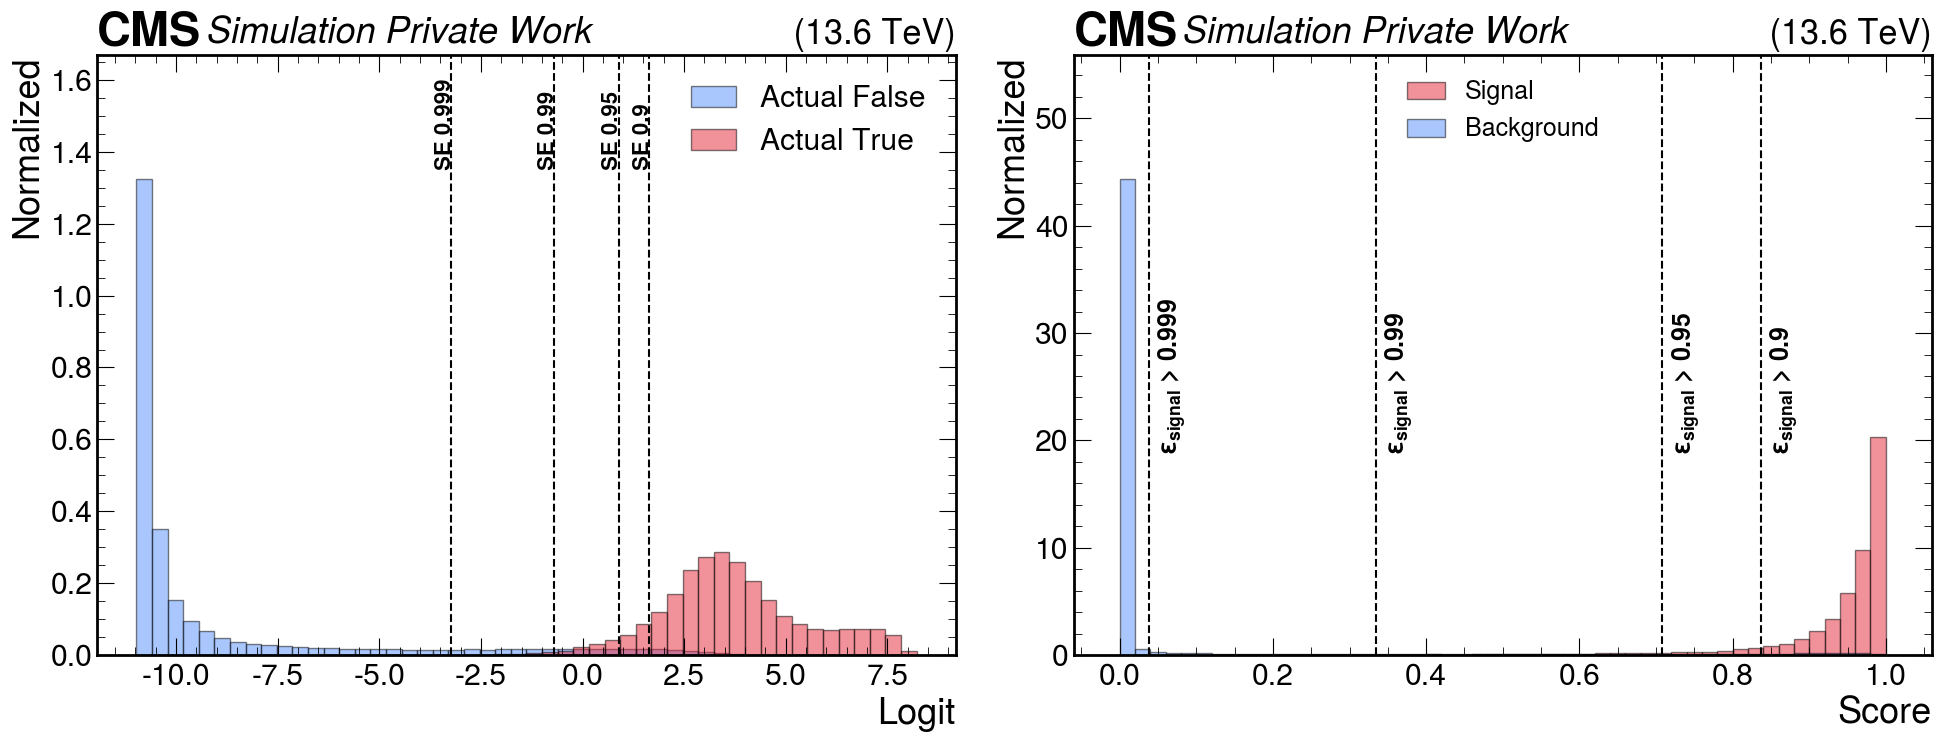

In [31]:
bins = 50
alpha = 0.5

tpr_threshold_arr = [0.9, 0.95, 0.99, 0.999]

fpr_s, tpr_s, threshold_s = roc_curve(targets, scores)
fpr_l, tpr_l, threshold_l = roc_curve(targets, logits)

logits_false = logits[targets == 0]
logits_true  = logits[targets == 1]
scores_false = scores[targets == 0]
scores_true  = scores[targets == 1]

score_thresh_vals = [
    (threshold_s[tpr_s >= tpr_cut].max() if np.any(tpr_s >= tpr_cut) else None)
    for tpr_cut in tpr_threshold_arr
]
logit_thresh_vals = [
    (threshold_l[tpr_l >= tpr_cut].max() if np.any(tpr_l >= tpr_cut) else None)
    for tpr_cut in tpr_threshold_arr
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

all_logits = np.concatenate([logits_false, logits_true])
bins_edges = np.histogram_bin_edges(all_logits, bins=bins)

ax1.hist(logits_false, bins=bins_edges, alpha=alpha, density=True,
           label="Actual False", color='C0', edgecolor='black')
ax1.hist(logits_true,  bins=bins_edges, alpha=alpha, density=True,
           label="Actual True",  color='C2', edgecolor='black')

_, ymax1 = ax1.get_ylim()

ax1.set_ylim(0, ymax1 * 1.2)

for tpr_cut, val in zip(tpr_threshold_arr, logit_thresh_vals):
    if val is None:
        continue
    ax1.axvline(val, color='k', linestyle='--')
    ax1.text(
        val - 0.4,
        ymax1 * 0.97,
        f"SE {tpr_cut}",
        rotation=90,
        va='bottom',
        ha='left',
        fontsize=16,
        fontweight='bold',
        color='k',
    )

ax1.set_xlabel("Logit")
ax1.set_ylabel("Normalized")
ax1.legend()


all_scores = np.concatenate([scores_false, scores_true])
bins_edges2 = np.histogram_bin_edges(all_scores, bins=bins)
ax2.hist(scores_true,  bins=bins_edges2, alpha=alpha, density=True,
           label="Signal",  color='C2', edgecolor='black')
ax2.hist(scores_false, bins=bins_edges2, alpha=alpha, density=True,
           label="Background", color='C0', edgecolor='black')

_, ymax2 = ax2.get_ylim()
ax2.set_ylim(0, ymax2 * 1.2)
ax2.set_xlim(-0.06, 1.06)
for tpr_cut, val in zip(tpr_threshold_arr, score_thresh_vals):
    if val is None:
        continue
    ax2.axvline(val, color='k', linestyle='--')
    ax2.text(
        val + 0.01,
        ymax2 * 0.4,
        r"$\epsilon_{signal}$ > " + f"{tpr_cut}",
        rotation=90,
        va='bottom',
        ha='left',
        fontsize=18,
        fontweight='bold',
        color='k',
    )

#ax2.set_yscale('log')
ax2.set_xlabel("Score")
ax2.set_ylabel("Normalized")
ax2.legend(loc='upper center', fontsize=18)

hep.cms.label(
    "Private Work",
    data=False,

    ax=ax1,
    com=13.6
)

hep.cms.label(
    "Private Work",
    data=False,

    ax=ax2,
    com=13.6
)

plt.tight_layout()
plt.show()

0.9 0.9744034044221738
0.95 0.9624979217301969
0.99 0.936972443824247
0.999 0.896916856714229


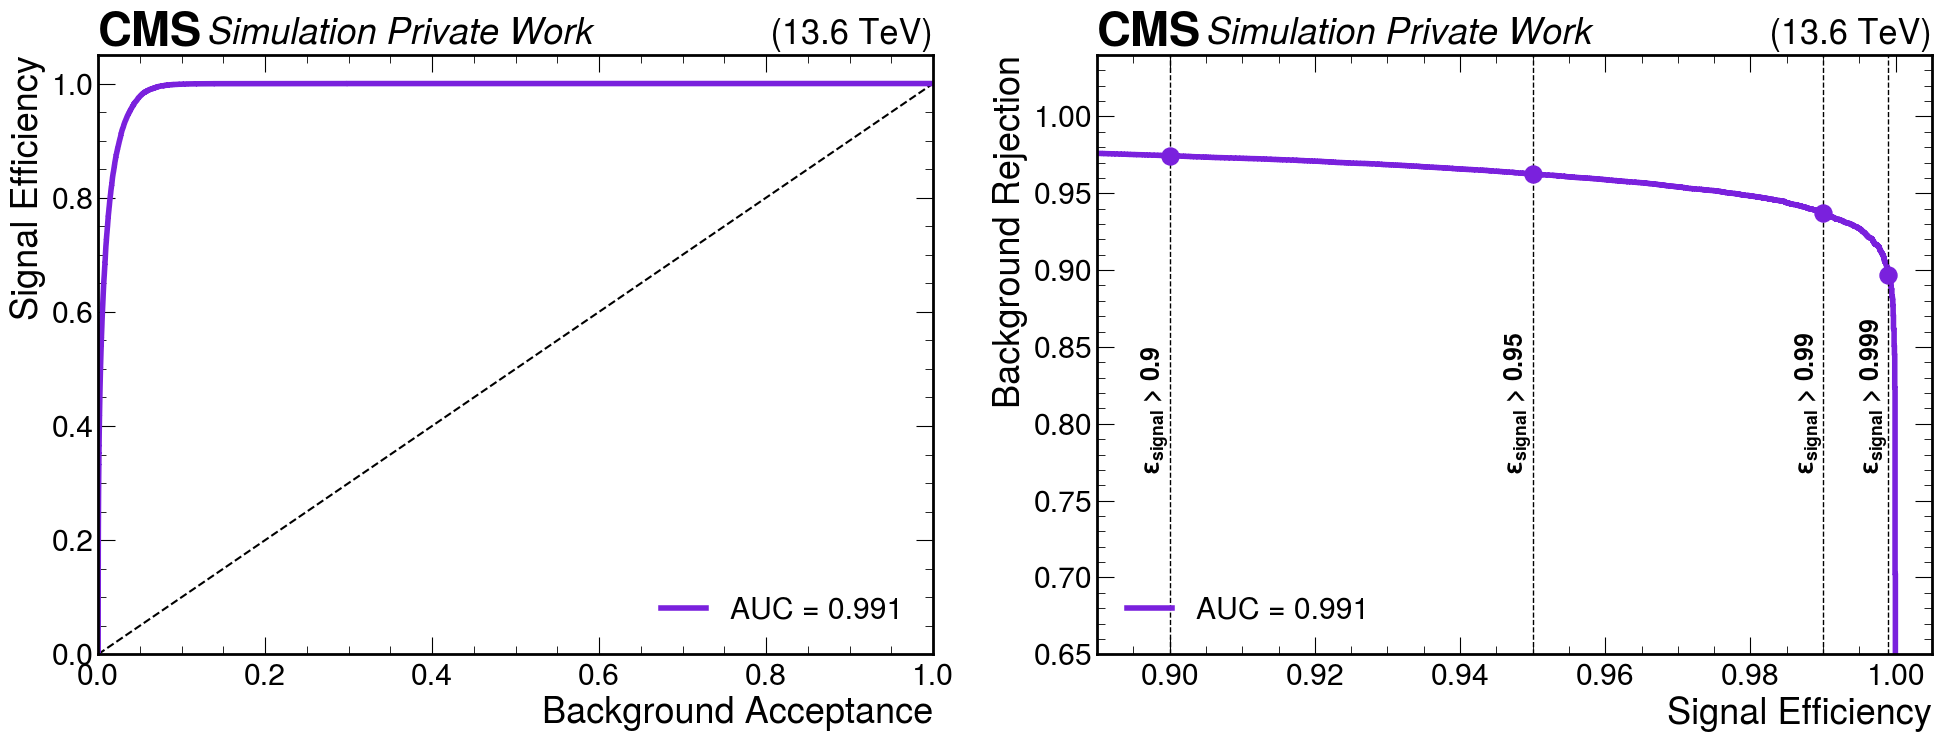

In [32]:
fpr_s, tpr_s, threshold_s = roc_curve(targets, scores)
roc_auc_s = auc(fpr_s, tpr_s)

fpr_l, tpr_l, threshold_l = roc_curve(targets, logits)
roc_auc_l = auc(fpr_l, tpr_l)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(fpr_s, tpr_s, label=f'AUC = {roc_auc_s:.3f}', color='C5', lw=4)
ax1.set_xlabel("Background Acceptance")
ax1.set_ylabel("Signal Efficiency")
#ax1.set_title("ROC Curve")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, None)
ax1.legend(loc="lower right")

hep.cms.label(
    "Private Work",
    data=False,
    ax=ax1,
    com=13.6
)

tnr_s = 1.0 - fpr_s
tnr_s_at = [
    (tnr_s[tpr_s >= tpr_cut].max() if np.any(tpr_s >= tpr_cut) else 0.0)
    for tpr_cut in tpr_threshold_arr
]

ax2.plot(tpr_s, tnr_s, alpha=1.0, color='C5', lw=4, label=f'AUC = {roc_auc_s:.3f}')
_, ymax2 = ax2.get_ylim()
#x_min2, x_max2 = ax2.get_xlim()
#x_offset = (x_max2 - x_min2) * 0.005

for tpr_cut, tnr_val in zip(tpr_threshold_arr, tnr_s_at):
    ax2.scatter(tpr_cut, tnr_val, color='C5', zorder=5, s=150)
    print(tpr_cut, tnr_val)
    ax2.axvline(x=tpr_cut, color='k', linestyle='--', linewidth=1)
    ax2.text(
        tpr_cut - 0.0042,
        ymax2 * 0.73,
        r"$\epsilon_{signal}$ > " + f"{tpr_cut}",
        rotation=90,
        va='bottom',
        ha='left',
        fontsize=18,
        fontweight='bold',
        color='k',
        zorder=6,
    )

ax2.set_xlabel("Signal Efficiency")
ax2.set_ylabel("Background Rejection")
ax2.set_xlim(0.89, 1.005)
ax2.set_ylim(0.65, 1.04)
ax2.legend(loc="lower left")

hep.cms.label(
    "Private Work",
    data=False,
    ax=ax2,
    com=13.6
)

plt.tight_layout()
plt.show()

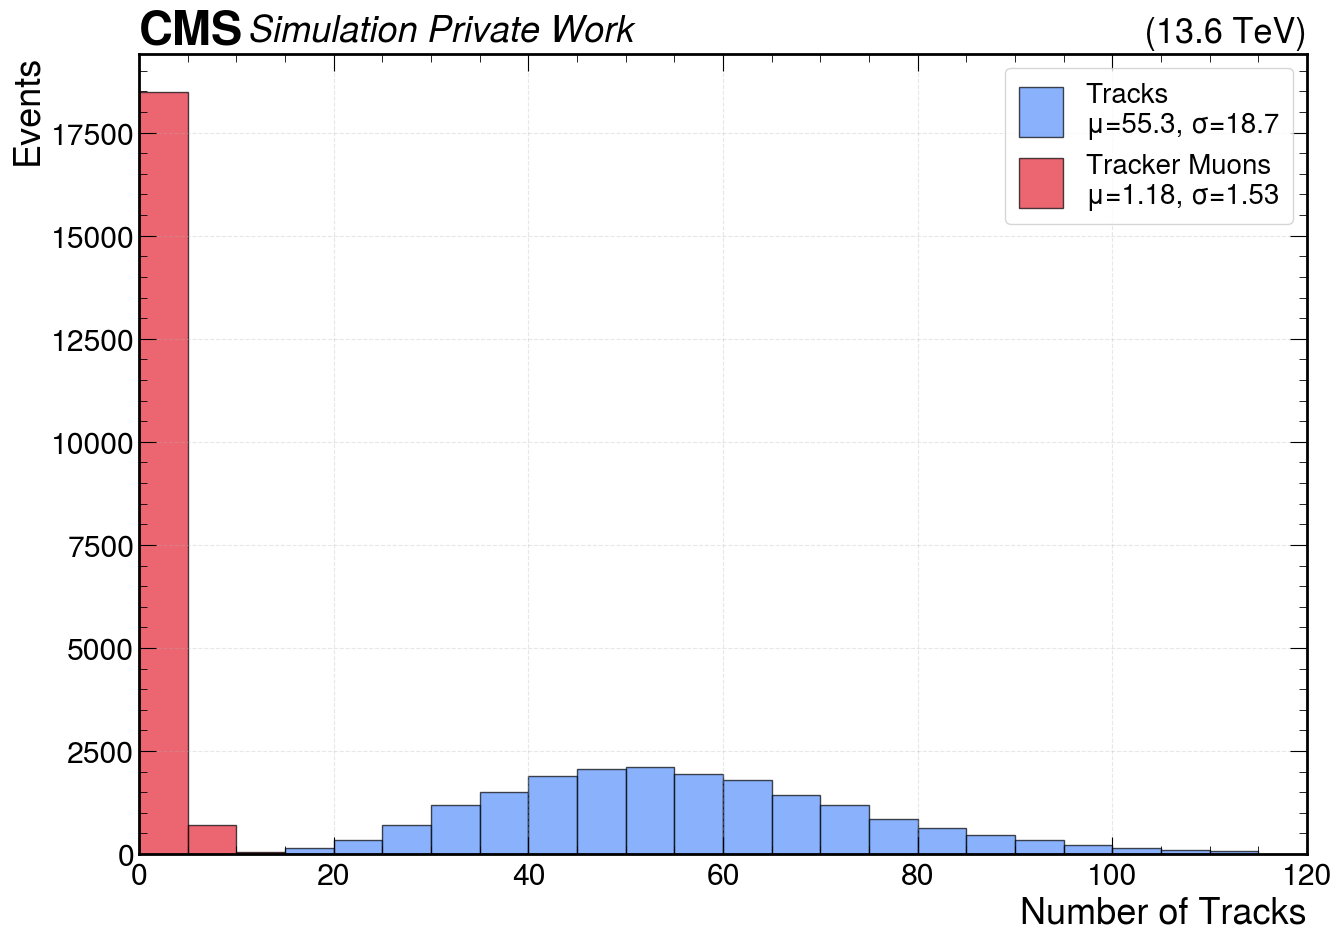

In [33]:
single_loader = DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=False,
    drop_last=True,
    collate_fn=InnerTrackSelectionDataset.collate,
)
model = model.to("cpu").eval()

n_tracks  = []
n_true_mu = []

with torch.no_grad():
    for i, batch in enumerate(single_loader):
        batch = batch.to("cpu")
        L = batch["track"].shape[1]
        n_tracks.append(L)
        tg = batch["target"][0].cpu().numpy()
        n_true_mu.append(int(tg.sum()))

max_count = max(max(n_tracks), max(n_true_mu))
bins = np.arange(0, 120, 5)
#bins = np.arange(0, 700, 20)


fig, ax = plt.subplots(figsize=(14, 10))

ax.hist(
    n_tracks,
    bins=bins,
    label=f"Tracks\nμ={np.mean(n_tracks):.1f}, σ={np.std(n_tracks):.1f}",
    alpha=0.7,
    edgecolor="black",
    color="C0",
)
ax.hist(
    n_true_mu,
    bins=bins,
    label=f"Tracker Muons\nμ={np.mean(n_true_mu):.2f}, σ={np.std(n_true_mu):.2f}",
    alpha=0.7,
    edgecolor="black",
    color="C2"
)

legend = ax.legend(
    loc="upper right",
    fontsize=20,
    handleheight=2.4,
    handlelength=1.6,
    frameon=True,
)

ax.set_xlim(0, 120)
ax.set_xlabel("Number of Tracks")
ax.set_ylabel("Events")
ax.grid(alpha=0.3, linestyle="--")

hep.cms.label("Private Work", data=False, ax=ax, com=13.6)

plt.tight_layout()
plt.show()

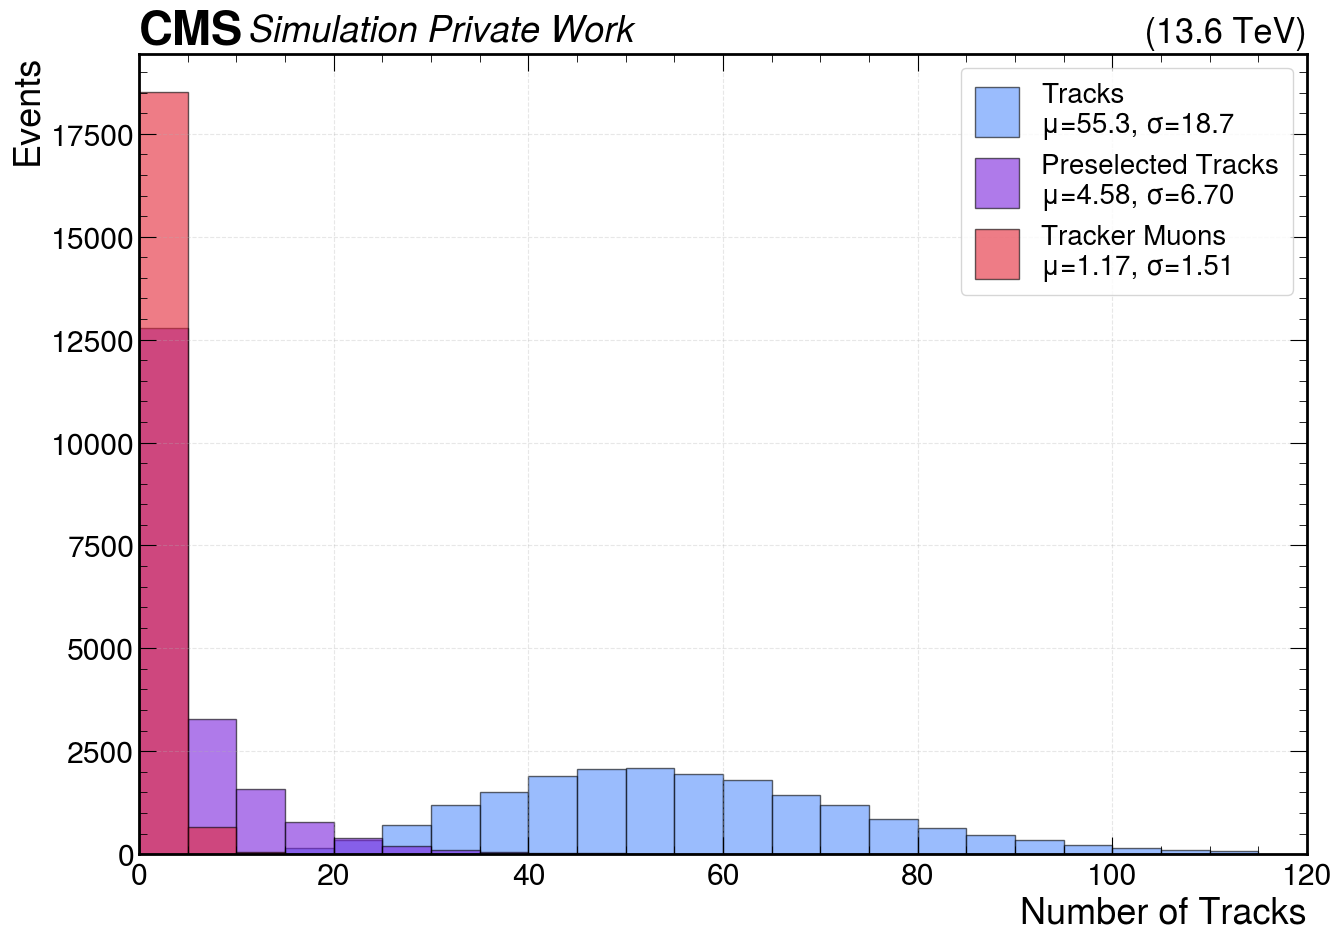

In [34]:
#N_EVENTS = 3000

single_loader = DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=False,
    drop_last=True,
    collate_fn=InnerTrackSelectionDataset.collate,
)
model = model.to("cpu").eval()

all_scores = []
all_targets = []
with torch.no_grad():
    for i, batch in enumerate(single_loader):
        #if i >= N_EVENTS:
        #    break
        batch = batch.to("cpu")
        out = model(batch)
        mask = batch["pad_masks"]["track"][0].cpu().numpy()
        sc = out["score"][0].cpu().numpy()[~mask]
        tg = batch["target"][0].cpu().numpy()[~mask]
        all_scores.append(sc)
        all_targets.append(tg)
all_scores = np.concatenate(all_scores)
all_targets = np.concatenate(all_targets)

fpr, tpr, thr = roc_curve(all_targets, all_scores)
threshold_099 = thr[tpr >= 0.99].max()

n_tracks     = []
n_pred_mu    = []
n_truepos_mu = []

with torch.no_grad():
    for i, batch in enumerate(single_loader):
        #if i >= N_EVENTS:
        #    break
        batch = batch.to("cpu")
        L = batch["track"].shape[1]
        n_tracks.append(L)

        out = model(batch)
        mask = batch["pad_masks"]["track"][0].cpu().numpy()
        sc = out["score"][0].cpu().numpy()[~mask]
        tg = batch["target"][0].cpu().numpy()[~mask].astype(bool)

        preds = sc >= threshold_099

        n_pred_mu.append(int(preds.sum()))
        n_truepos_mu.append(int((preds & tg).sum()))

max_count = max(max(n_tracks), max(n_pred_mu), max(n_truepos_mu))
#bins = np.arange(max_count + 2) - 0.5
bins = np.arange(0, 120, 5)
#bins = np.arange(0, 700, 20)


fig, ax = plt.subplots(figsize=(14, 10))

ax.hist(
    n_tracks,
    bins=bins,
    label=f"Tracks\nμ={np.mean(n_tracks):.1f}, σ={np.std(n_tracks):.1f}",
    alpha=0.6,
    edgecolor="black",
    color="C0"
)
ax.hist(
    n_pred_mu,
    bins=bins,
    label=f"Preselected Tracks\nμ={np.mean(n_pred_mu):.2f}, σ={np.std(n_pred_mu):.2f}",
    alpha=0.6,
    edgecolor="black",
    color="C5"
)
ax.hist(
    n_truepos_mu,
    bins=bins,
    label=f"Tracker Muons\nμ={np.mean(n_truepos_mu):.2f}, σ={np.std(n_truepos_mu):.2f}",
    alpha=0.6,
    edgecolor="black",
    color="C2"
)

legend = ax.legend(
    loc="upper right",
    fontsize=20,
    handleheight=2.4,
    handlelength=1.6,
    frameon=True,
)

ax.set_xlim(0, 120)
ax.set_xlabel("Number of Tracks")
ax.set_ylabel("Events")
#ax.set_xticks(np.arange(0, max_count + 1, max(1, max_count // 10)))
#ax.legend(loc="upper right")
ax.grid(alpha=0.3, linestyle="--")

hep.cms.label("Private Work", data=False, ax=ax, com=13.6)

plt.tight_layout()
plt.show()